In [ ]:
import torch
from PIL import Image
from diffusers import FluxPipeline
from einops import rearrange
from autoencoder import TopkSparseAutoencoder
from pathlib import Path
import hashlib
import re
import random


# ===== CONFIGURATION - Change these to create different test runs =====
# FLUX_MODEL = "black-forest-labs/FLUX.1-schnell"  # or "black-forest-labs/FLUX.1-dev"
FLUX_MODEL = "black-forest-labs/FLUX.1-dev"
# SAE_MODEL = "RE-N-Y/cc3m-transformer_blocks.0-0" # MMDiT layer 0, text stream
# SAE_MODEL = "RE-N-Y/cc3m-transformer_blocks.0-1" # MMDiT layer 0, image stream
# SAE_MODEL = "RE-N-Y/cc3m-transformer_blocks.18-0" # MMDiT layer 18, image stream
# SAE_MODEL = "RE-N-Y/cc3m-transformer_blocks.18-1" # MMDiT layer 18, image stream
# SAE_MODEL = "RE-N-Y/cc3m-single_transformer_blocks.9" # DiT layer 9, text/image stream
SAE_MODEL = "RE-N-Y/cc3m-single_transformer_blocks.37" # DiT layer 9, text/image stream

# Your prompt
prompt = "a woman with pink hair standing in a dark room (no light), holding a sign that says `SAE test ' (no light, regular paper sign), an apple is floating in the air at the [25,50] pixel of the image"
# prompt = "a woman with pink hair standing in a forest, holding a sign"
# prompt = "a woman with pink hair standing in a forest, holding a sign that says ‘Skipping flux blocks‘"
# prompt = "a woman with pink hair standing in a dark room, holding a sign that says `SAE test ‘, behind her left is a blue light, right is a red light"
# prompt = "a woman with pink hair standing in a dark room, holding a sign that says `SAE test ‘ (no light, regular paper sign), behind her a blue light is shine from 45 deg from top left, a red light is shine from 45 deg from bottom right"
# prompt = "a woman with pink hair standing in a dark room (no light), holding a sign that says `SAE test ‘ (no light, regular paper sign), an apple is floating in the air at the [25,50] pixel of the image"

# test_strengths = [1.1, 5.0, 10.0, 20.0, 50.0]  # Adjust as needed
# For Gytis-style steering, use lower strengths (0.1-5.0)
# For CLIP embeddings (Gytis's case), strength=40 works because CLIP embeddings are normalized differently
# For FLUX internal activations, use much lower strengths
import numpy as np
test_strengths = np.arange(0.5, 5.0, 0.5).tolist()  # [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

# ===== CREATE OUTPUT FOLDER BASED ON TEST CONFIGURATION =====
# Create folder name from configuration
prompt_hash = hashlib.md5(prompt.encode()).hexdigest()[:8]  # Short hash of prompt
flux_model_name = FLUX_MODEL.split("/")[-1].replace(".", "-")  # e.g., "FLUX-1-schnell"
strength_str = f"strengths-{min(test_strengths)}-to-{max(test_strengths)}"
sae_suffix = "-".join(SAE_MODEL.split("/")[-1].split("-")[-2:])  # e.g., "blocks.0-1" or "blocks.0-0"
output_folder = f"steering_test_{flux_model_name}_{sae_suffix}_{prompt_hash}_{strength_str}"

# Create output directory and folder in ./output/
output_base = Path("./output")
output_base.mkdir(parents=True, exist_ok=True)
output_path = output_base / output_folder
output_path.mkdir(parents=True, exist_ok=True)

print(f"📁 Output folder: {output_path}/")
print(f"   All images will be saved here")
print(f"   Config: FLUX={flux_model_name}, prompt_hash={prompt_hash}, strengths={test_strengths}")

# ===== LOAD MODELS =====
flux_sae = TopkSparseAutoencoder.from_pretrained(SAE_MODEL)

# Load FLUX pipeline
pipe = FluxPipeline.from_pretrained(
    FLUX_MODEL,
    torch_dtype=torch.bfloat16
)
pipe = pipe.to("cuda")

# Configuration for the SAE (supports both "transformer_blocks.X-Y" and "single_transformer_blocks.X")
sae_match = re.search(r"(?:transformer_blocks|single_transformer_blocks)\.(\d+)(?:-\d+)?", SAE_MODEL)
if sae_match:
    block_num = sae_match.group(1)
    if "single_transformer_blocks" in SAE_MODEL:
        hook_location = f"single_transformer_blocks.{block_num}.attn"
    else:
        hook_location = f"transformer_blocks.{block_num}.attn"
else:
    # Fallback/default in case SAE_MODEL pattern is different
    hook_location = "transformer_blocks.0.attn"

# Autodetect stream from SAE_MODEL name; if "-1" at end, use stream=1 (key), else stream=0 (query)
sae_stream_match = re.search(r'transformer_blocks\.\d+-(\d)$', SAE_MODEL)
if sae_stream_match:
    stream = int(sae_stream_match.group(1))
else:
    stream = 0  # Default fallback to query stream

print(f"🔎 Using SAE hook location: {hook_location}")
print(f"🔎 Stream (0=query, 1=key): {stream}")

device = "cuda"
generator = torch.Generator(device=device).manual_seed(42)

# ===== ORIGINAL GENERATION (No steering) =====
print("Generating original image...")
original_image = pipe(
    prompt=prompt,
    height=512,
    width=512,
    num_inference_steps=20,
    guidance_scale=3.5,
    generator=generator,
).images[0]
original_image.save(output_path / "flux_original.png")
print(f"Original image saved to {output_path}/flux_original.png")

# Move SAE to GPU for faster processing and set to eval mode
flux_sae = flux_sae.to(device)
flux_sae.eval()  # Important: SAE should be in eval mode for inference

# ===== SAE STEERING: Increase a specific feature =====
# Method 1: Full encode-decode surgery (can introduce reconstruction error)

# def create_surgery_hook(sae, feature_idx, strength, stream=0, method="additive"):
#     """
#     Create a hook that applies SAE steering to modify activations.
    
#     Args:
#         sae: The TopK SAE model
#         feature_idx: Index of feature to boost (0 to pages-1)
#         strength: How much to boost the feature (use 0.1-2.0 for FLUX, not 5.0+)
#         stream: Which stream to modify (0=query, 1=key) for transformer_blocks.0.attn
#         method: "additive" (add feature direction) or "surgery" (full encode-decode)
#     """
#     def hook_fn(module, input, output):
#         # transformer_blocks.0.attn returns tuple (query, key)
#         if isinstance(output, tuple):
#             query, key = output
#             # Select which stream to modify based on stream parameter
#             target = query if stream == 0 else key
#             other = key if stream == 0 else query
            
#             # Reshape to flatten spatial dimensions: (batch, seq, height, width, dim) -> (batch*seq*h*w, dim)
#             original_shape = target.shape
#             target_flat = rearrange(target, "b ... d -> (b ...) d")
            
#             # Ensure input dtype matches SAE weights (handle bfloat16 from FLUX)
#             sae_dtype = next(sae.parameters()).dtype
#             original_dtype = target_flat.dtype
#             if target_flat.dtype != sae_dtype:
#                 target_flat = target_flat.to(sae_dtype)
            
#             # Ensure SAE and input are on same device
#             sae_device = next(sae.parameters()).device
#             if target_flat.device != sae_device:
#                 target_flat = target_flat.to(sae_device)
            
#             # Apply steering
#             with torch.no_grad():  # Steering doesn't need gradients
#                 if method == "additive":
#                     # METHOD 1: Additive steering - add feature direction directly (less noisy)
#                     # Get the decoder weight for this feature (represents the feature direction)
#                     feature_direction = sae.decoder.weight[:, feature_idx]  # Shape: (features,)
#                     # Add scaled feature direction to activations
#                     target_steered = target_flat + strength * feature_direction.unsqueeze(0)
#                 else:
#                     # METHOD 2: Full surgery - encode, modify, decode (more reconstruction error)
#                     target_steered = sae.surgery(target_flat, k=feature_idx, strength=strength)
            
#             # Convert back to original dtype and device
#             target_steered = target_steered.to(dtype=original_dtype, device=target.device)
            
#             # Reshape back to original shape
#             target_reshaped = target_steered.reshape(original_shape)
            
#             # Return modified output (target stream modified, other stream unchanged)
#             return (target_reshaped, other) if stream == 0 else (other, target_reshaped)
#         else:
#             # If not a tuple, just apply steering directly
#             original_shape = output.shape
#             output_flat = rearrange(output, "b ... d -> (b ...) d")
            
#             # Ensure input dtype matches SAE weights
#             sae_dtype = next(sae.parameters()).dtype
#             original_dtype = output_flat.dtype
#             if output_flat.dtype != sae_dtype:
#                 output_flat = output_flat.to(sae_dtype)
            
#             # Ensure SAE and input are on same device
#             sae_device = next(sae.parameters()).device
#             if output_flat.device != sae_device:
#                 output_flat = output_flat.to(sae_device)
            
#             with torch.no_grad():
#                 if method == "additive":
#                     # Additive steering
#                     feature_direction = sae.decoder.weight[:, feature_idx]
#                     output_steered = output_flat + strength * feature_direction.unsqueeze(0)
#                 else:
#                     # Full surgery
#                     output_steered = sae.surgery(output_flat, k=feature_idx, strength=strength)
            
#             # Convert back to original dtype and device
#             output_steered = output_steered.to(dtype=original_dtype, device=output.device)
            
#             # Reshape back to original shape
#             output_reshaped = output_steered.reshape(original_shape)
#             return output_reshaped
    
#     return hook_fn
    
def create_surgery_hook(sae, feature_idx, strength, stream=0, method="gytis_style"):
    """
    Create a hook with Gytis-style steering.
    """
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            query, key = output
            target = query if stream == 0 else key
            other = key if stream == 0 else query
            
            original_shape = target.shape
            target_flat = rearrange(target, "b ... d -> (b ...) d")
            
            # Ensure dtype/device match
            sae_dtype = next(sae.parameters()).dtype
            sae_device = next(sae.parameters()).device
            target_flat = target_flat.to(dtype=sae_dtype, device=sae_device)
            
            # Use Gytis-style surgery
            with torch.no_grad():
                if method == "gytis_style":
                    target_steered = sae.surgery_gytis_style(
                        target_flat, 
                        k=feature_idx, 
                        strength=strength,
                        fallback_to_additive=True
                    )
                elif method == "additive":
                    feature_direction = sae.decoder.weight[:, feature_idx]
                    target_steered = target_flat + strength * feature_direction.unsqueeze(0)
                else:  # original surgery
                    target_steered = sae.surgery(target_flat, k=feature_idx, strength=strength)
            
            # Convert back
            target_steered = target_steered.to(dtype=target.dtype, device=target.device)
            target_reshaped = target_steered.reshape(original_shape)
            
            return (target_reshaped, other) if stream == 0 else (other, target_reshaped)
        else:
            # Handle non-tuple output similarly
            original_shape = output.shape
            output_flat = rearrange(output, "b ... d -> (b ...) d")
            
            # Ensure input dtype matches SAE weights
            sae_dtype = next(sae.parameters()).dtype
            original_dtype = output_flat.dtype
            if output_flat.dtype != sae_dtype:
                output_flat = output_flat.to(sae_dtype)
            
            # Ensure SAE and input are on same device
            sae_device = next(sae.parameters()).device
            if output_flat.device != sae_device:
                output_flat = output_flat.to(sae_device)
            
            with torch.no_grad():
                if method == "gytis_style":
                    output_steered = sae.surgery_gytis_style(
                        output_flat,
                        k=feature_idx,
                        strength=strength,
                        fallback_to_additive=True
                    )
                elif method == "additive":
                    # Additive steering
                    feature_direction = sae.decoder.weight[:, feature_idx]
                    output_steered = output_flat + strength * feature_direction.unsqueeze(0)
                else:  # original surgery
                    output_steered = sae.surgery(output_flat, k=feature_idx, strength=strength)
            
            # Convert back to original dtype and device
            output_steered = output_steered.to(dtype=original_dtype, device=output.device)
            
            # Reshape back to original shape
            output_reshaped = output_steered.reshape(original_shape)
            return output_reshaped
    
    return hook_fn

# Try steering with different features and strengths

# First, run analysis to find top features (see below), then use those
# For now, test with a few features
test_features = random.sample(range(49152), 3)  # Randomly select 3 features from feature indices 0 to 49151

# Use Gytis-style steering (recommended - only boosts active features)
steering_method = "gytis_style"  # Recommended: only boosts features in top-k
# steering_method = "additive"  # Alternative: direct feature direction addition
# steering_method = "surgery"  # Original: forces activation (more disruptive)
# test_strengths defined at top of cell (in CONFIGURATION section)

for feature_idx in test_features:
    # for strength in [0.5, 1.0]:  # Test with moderate strengths first
    for strength in test_strengths:  # Start with small strengths
        print(f"\nSteering with feature {feature_idx}, strength {strength}, method={steering_method}...")
        
        # Register hook for this feature
        hook_handle = pipe.transformer.get_submodule(hook_location).register_forward_hook(
            create_surgery_hook(flux_sae, feature_idx=feature_idx, strength=strength, 
                              stream=stream, method=steering_method)
        )
    
    try:
        # Generate image with steering
        steered_image = pipe(
            prompt=prompt,
            height=512,
            width=512,
            num_inference_steps=20,
            guidance_scale=3.5,
            generator=torch.Generator(device=device).manual_seed(42),  # Same seed for comparison
        ).images[0]
        
        steered_image.save(output_path / f"flux_steered_feature_{feature_idx}_strength_{strength}.png")
        print(f"Steered image saved to {output_path}/flux_steered_feature_{feature_idx}_strength_{strength}.png")
    finally:
        # Always remove hook to avoid memory leaks
        hook_handle.remove()

# ===== EXPLORE FEATURE ACTIVATIONS =====
print("\nAnalyzing feature activations...")

# Extract activations to see which features activate for this prompt
activation_hook_output = None

def activation_hook(module, input, output):
    global activation_hook_output
    if isinstance(output, tuple):
        query, key = output
        activation_hook_output = query if stream == 0 else key
    else:
        activation_hook_output = output
    return output

hook_handle = pipe.transformer.get_submodule(hook_location).register_forward_hook(activation_hook)

# Generate once to capture activations
_ = pipe(
    prompt=prompt,
    height=512,
    width=512,
    num_inference_steps=1,  # Just 1 step to get activations
    guidance_scale=3.5,
    generator=torch.Generator(device=device).manual_seed(42),
)

hook_handle.remove()

if activation_hook_output is not None:
    # Flatten and encode
    activations_flat = rearrange(activation_hook_output, "b ... d -> (b ...) d")
    feature_activations = flux_sae.encode(activations_flat)  # Shape: (batch*seq, num_features)
    
    # Find top activating features
    feature_sums = feature_activations.abs().sum(dim=0)  # Sum across all tokens
    top_features, top_indices = torch.topk(feature_sums, k=10)
    
    print("\nTop 10 activating features:")
    for i, (feat_idx, feat_act) in enumerate(zip(top_indices.cpu().tolist(), top_features.cpu().tolist())):
        print(f"  Feature {feat_idx}: total activation = {feat_act:.2f}")
    
    print(f"\nTry steering with these top features to see their effects!")
    print("Example: Use feature_idx={} in the steering loop above".format(top_indices[0].item()))
    
    # ===== OPTIONAL: Test steering with top features =====
    print("\n" + "="*60)
    print("Testing steering with TOP activating features...")
    print("="*60)
    
    # Use top 3 features with additive method (less noisy)
    top_features_to_test = top_indices[:3].cpu().tolist()
    
    for feat_idx in top_features_to_test:
        for strength in test_strengths: 
            print(f"\nSteering top feature {feat_idx} with strength {strength} (additive)...")
            
            hook_handle = pipe.transformer.get_submodule(hook_location).register_forward_hook(
                create_surgery_hook(flux_sae, feature_idx=feat_idx, strength=strength,
                                  stream=stream, method="additive")
            )
            try:
                steered_image = pipe(
                    prompt=prompt,
                    height=512,
                    width=512,
                    num_inference_steps=20,
                    guidance_scale=3.5,
                    generator=torch.Generator(device=device).manual_seed(42),
                ).images[0]
                
                steered_image.save(output_path / f"flux_top_feature_{feat_idx}_strength_{strength}.png")
                print(f"  Saved: {output_path}/flux_top_feature_{feat_idx}_strength_{strength}.png")
            finally:
                hook_handle.remove()


📁 Output folder: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/
   All images will be saved here
   Config: FLUX=FLUX-1-dev, prompt_hash=16014404, strengths=[2, 12, 22, 32, 42, 52, 62, 72, 82, 92]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

🔎 Using SAE hook location: single_transformer_blocks.37.attn
🔎 Stream (0=query, 1=key): 0
Generating original image...


  0%|          | 0/20 [00:00<?, ?it/s]

Original image saved to output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_original.png

Steering with feature 10, strength 2, method=surgery...

Steering with feature 10, strength 12, method=surgery...

Steering with feature 10, strength 22, method=surgery...

Steering with feature 10, strength 32, method=surgery...

Steering with feature 10, strength 42, method=surgery...

Steering with feature 10, strength 52, method=surgery...

Steering with feature 10, strength 62, method=surgery...

Steering with feature 10, strength 72, method=surgery...

Steering with feature 10, strength 82, method=surgery...

Steering with feature 10, strength 92, method=surgery...


  0%|          | 0/20 [00:00<?, ?it/s]

Steered image saved to output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_steered_feature_10_strength_92.png

Steering with feature 50, strength 2, method=surgery...

Steering with feature 50, strength 12, method=surgery...

Steering with feature 50, strength 22, method=surgery...

Steering with feature 50, strength 32, method=surgery...

Steering with feature 50, strength 42, method=surgery...

Steering with feature 50, strength 52, method=surgery...

Steering with feature 50, strength 62, method=surgery...

Steering with feature 50, strength 72, method=surgery...

Steering with feature 50, strength 82, method=surgery...

Steering with feature 50, strength 92, method=surgery...


  0%|          | 0/20 [00:00<?, ?it/s]

Steered image saved to output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_steered_feature_50_strength_92.png

Steering with feature 100, strength 2, method=surgery...

Steering with feature 100, strength 12, method=surgery...

Steering with feature 100, strength 22, method=surgery...

Steering with feature 100, strength 32, method=surgery...

Steering with feature 100, strength 42, method=surgery...

Steering with feature 100, strength 52, method=surgery...

Steering with feature 100, strength 62, method=surgery...

Steering with feature 100, strength 72, method=surgery...

Steering with feature 100, strength 82, method=surgery...

Steering with feature 100, strength 92, method=surgery...


  0%|          | 0/20 [00:00<?, ?it/s]

Steered image saved to output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_steered_feature_100_strength_92.png

Analyzing feature activations...


  0%|          | 0/1 [00:00<?, ?it/s]


Top 10 activating features:
  Feature 100: total activation = 152529.83
  Feature 29772: total activation = 20710.67
  Feature 39324: total activation = 20097.06
  Feature 39539: total activation = 19858.05
  Feature 19036: total activation = 19398.29
  Feature 12530: total activation = 18844.37
  Feature 31443: total activation = 16381.87
  Feature 40513: total activation = 15495.58
  Feature 14832: total activation = 14073.46
  Feature 4458: total activation = 13380.66

Try steering with these top features to see their effects!
Example: Use feature_idx=100 in the steering loop above

Testing steering with TOP activating features...

Steering top feature 100 with strength 2 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_2.png

Steering top feature 100 with strength 12 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_12.png

Steering top feature 100 with strength 22 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_22.png

Steering top feature 100 with strength 32 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_32.png

Steering top feature 100 with strength 42 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_42.png

Steering top feature 100 with strength 52 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_52.png

Steering top feature 100 with strength 62 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_62.png

Steering top feature 100 with strength 72 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_72.png

Steering top feature 100 with strength 82 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_82.png

Steering top feature 100 with strength 92 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_100_strength_92.png

Steering top feature 29772 with strength 2 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_2.png

Steering top feature 29772 with strength 12 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_12.png

Steering top feature 29772 with strength 22 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_22.png

Steering top feature 29772 with strength 32 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_32.png

Steering top feature 29772 with strength 42 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_42.png

Steering top feature 29772 with strength 52 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_52.png

Steering top feature 29772 with strength 62 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_62.png

Steering top feature 29772 with strength 72 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_72.png

Steering top feature 29772 with strength 82 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_82.png

Steering top feature 29772 with strength 92 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_29772_strength_92.png

Steering top feature 39324 with strength 2 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_2.png

Steering top feature 39324 with strength 12 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_12.png

Steering top feature 39324 with strength 22 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_22.png

Steering top feature 39324 with strength 32 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_32.png

Steering top feature 39324 with strength 42 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_42.png

Steering top feature 39324 with strength 52 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_52.png

Steering top feature 39324 with strength 62 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_62.png

Steering top feature 39324 with strength 72 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_72.png

Steering top feature 39324 with strength 82 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_82.png

Steering top feature 39324 with strength 92 (additive)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Saved: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_top_feature_39324_strength_92.png

Done! Compare original vs steered images to see feature effects.

WHY WERE IMAGES NOISY?
- Strength 5.0 was too high for FLUX (use 0.1-2.0 instead)
- Full encode-decode surgery introduces reconstruction error
- Hook applied at every diffusion step (20x amplification)
- Try 'additive' method instead of 'surgery' for cleaner results
- Use top activating features (they activate more reliably)


Using folder from previous cell: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92
Found 54 generated images in output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/


/tmp/ipykernel_2809498/615533981.py:318: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave small space for suptitle



✅ Comparison grid saved to: output/steering_test_FLUX-1-dev_cc3m-single_transformer_blocks.37_16014404_strengths-2-to-92/flux_steering_comparison.png
   Displaying 54 images in 14x4 grid


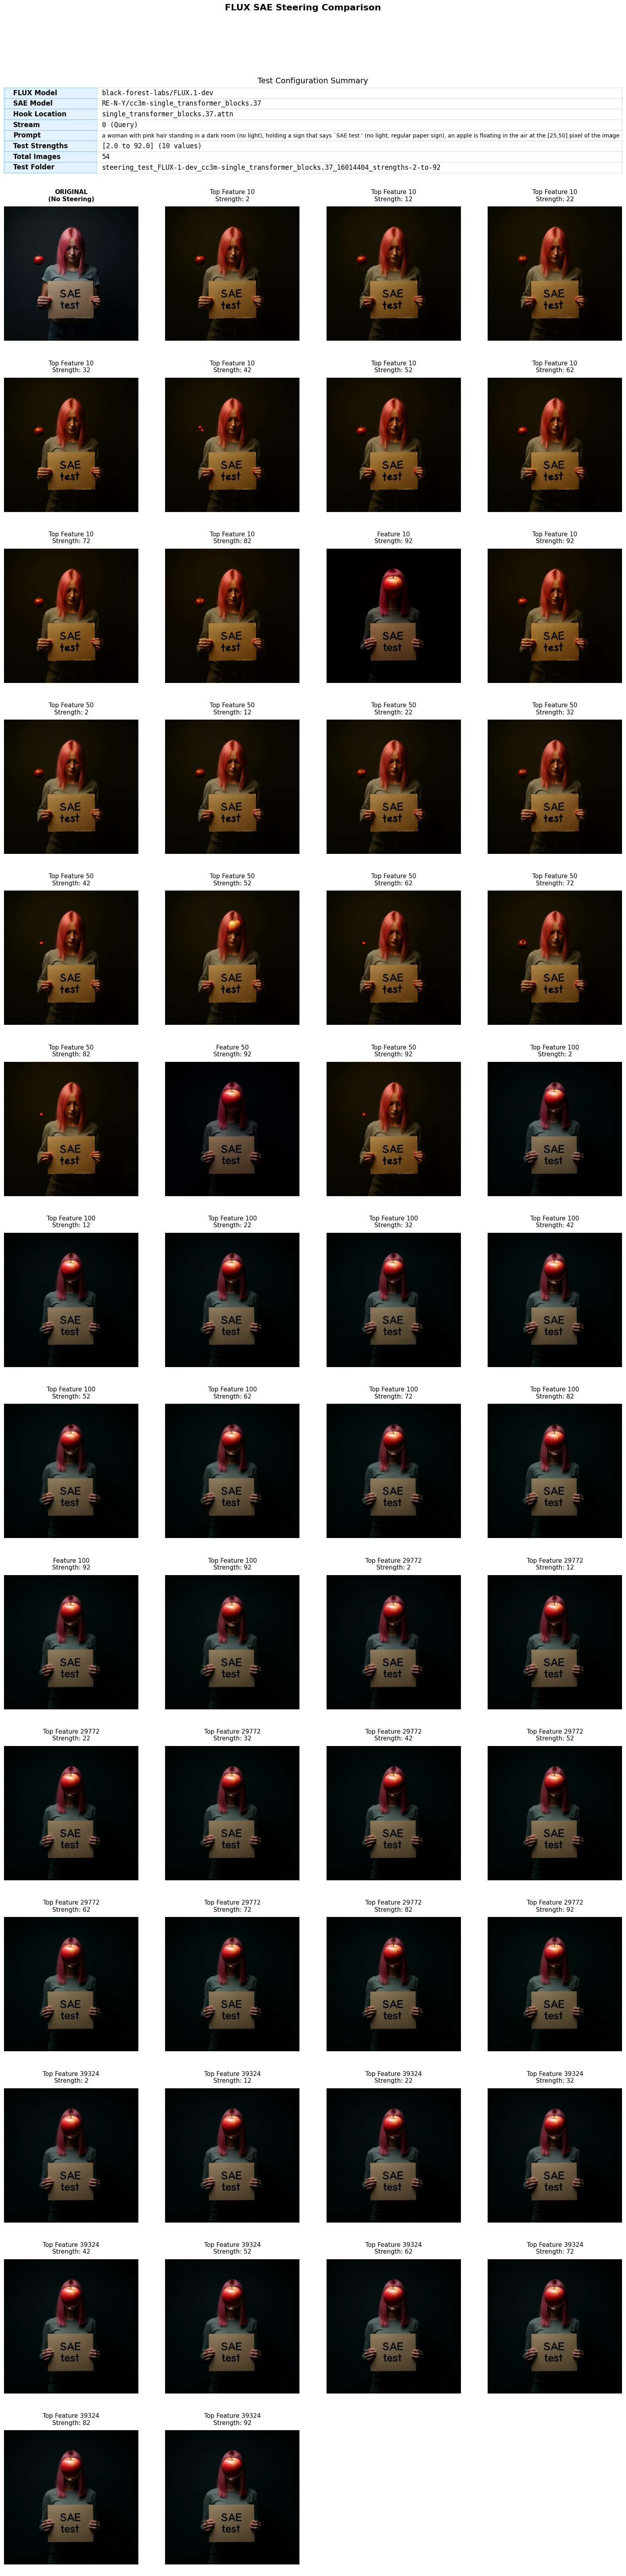

In [102]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
import glob
import re

# ===== CONFIGURATION - Specify which test folder to visualize =====
# Option 1: Use the folder from the previous cell (if output_path variable exists)
try:
    # Try output_path first (it's a Path object)
    if 'output_path' in locals() or 'output_path' in globals():
        folder_path = output_path
        visualize_folder = output_path.name
        print(f"Using folder from previous cell: {folder_path}")
    else:
        raise NameError
except NameError:
    # Option 2: Specify folder manually, or use most recent
    visualize_folder = None  # Set to folder name if you want to load a specific test
    
    # Option 3: Find most recent folder in ./output/
    output_base = Path("./output")
    if output_base.exists():
        test_folders = sorted(output_base.glob("steering_test_*"), key=lambda x: x.stat().st_mtime, reverse=True)
        if test_folders:
            folder_path = test_folders[0]
            visualize_folder = folder_path.name
            print(f"Using most recent folder in ./output/: {folder_path}")
        else:
            print("No test folders found in ./output/! Run the steering cell first.")
            folder_path = None
    else:
        print("Output directory ./output/ not found! Run the steering cell first.")
        folder_path = None

if folder_path and folder_path.exists():
    # Find all generated images in the specified folder
    image_files = sorted(glob.glob(str(folder_path / "flux_*.png")))
    # Drop the file 'flux_steering_comparison.png' from the list if present
    image_files = [f for f in image_files if not f.endswith('flux_steering_comparison.png')]
    print(f"Found {len(image_files)} generated images in {folder_path}/")
    
    # ===== EXTRACT CONFIGURATION FROM FOLDER NAME OR GLOBAL SCOPE =====
    config_info = {}
    
    # Try to get from global scope first (more accurate)
    # Use get_ipython().user_ns to access variables from previous cells in Jupyter
    try:
        import __main__
        namespace = __main__.__dict__
    except:
        namespace = globals()
    
    # Try to get variables from namespace
    if 'FLUX_MODEL' in namespace:
        config_info['FLUX Model'] = namespace['FLUX_MODEL']
    elif 'FLUX_MODEL' in globals():
        config_info['FLUX Model'] = globals()['FLUX_MODEL']
    
    if 'SAE_MODEL' in namespace:
        config_info['SAE Model'] = namespace['SAE_MODEL']
    elif 'SAE_MODEL' in globals():
        config_info['SAE Model'] = globals()['SAE_MODEL']
    
    if 'prompt' in namespace:
        config_info['Prompt'] = namespace['prompt']
    elif 'prompt' in globals():
        config_info['Prompt'] = globals()['prompt']
    
    if 'test_strengths' in namespace:
        config_info['Test Strengths'] = namespace['test_strengths']
    elif 'test_strengths' in globals():
        config_info['Test Strengths'] = globals()['test_strengths']
    
    if 'hook_location' in namespace:
        config_info['Hook Location'] = namespace['hook_location']
    elif 'hook_location' in globals():
        config_info['Hook Location'] = globals()['hook_location']
    
    if 'stream' in namespace:
        config_info['Stream'] = namespace['stream']
    elif 'stream' in globals():
        config_info['Stream'] = globals()['stream']
    
    # Parse folder name as fallback
    folder_name = folder_path.name if hasattr(folder_path, 'name') else str(folder_path)
    if 'steering_test_' in folder_name:
        # Extract model name (e.g., FLUX-1-dev -> FLUX.1-dev)
        if 'FLUX Model' not in config_info or not config_info['FLUX Model']:
            model_match = re.search(r'(FLUX-[^-]+-[^-]+)', folder_name)
            if model_match:
                config_info['FLUX Model'] = model_match.group(1).replace('-', '.')
        
        # Extract SAE location (e.g., transformer_blocks.0-0)
        if 'SAE Model' not in config_info or not config_info['SAE Model']:
            sae_match = re.search(r'(transformer_blocks\.\d+-\d+|single_transformer_blocks\.\d+)', folder_name)
            if sae_match:
                config_info['SAE Model'] = sae_match.group(1)
        
        # Extract strength range
        if 'Test Strengths' not in config_info or not config_info['Test Strengths']:
            strength_match = re.search(r'strengths-([\d.]+)-to-([\d.]+)', folder_name)
            if strength_match:
                min_str = float(strength_match.group(1))
                max_str = float(strength_match.group(2))
                config_info['Test Strengths'] = f"{min_str} to {max_str}"
else:
    image_files = []
    print("No folder specified or found.")
    config_info = {}

if len(image_files) == 0:
    print("No images found! Run the steering cell first.")
else:
    # Separate original from steered
    original_files = [f for f in image_files if "original" in f]
    steered_files = [f for f in image_files if "original" not in f]
    
    # Sort steered files by feature and strength
    def sort_key(f):
        """Sort by: feature_idx, then strength"""
        name = Path(f).stem
        try:
            # Extract feature index and strength
            parts = name.split("_")
            feat_idx = None
            strength = None
            for i, part in enumerate(parts):
                if part == "feature" and i+1 < len(parts):
                    try:
                        feat_idx = int(parts[i+1])
                    except:
                        pass
                if part == "strength" and i+1 < len(parts):
                    try:
                        strength = float(parts[i+1])
                    except:
                        pass
            return (feat_idx or 999999, strength or 0)
        except:
            return (999999, 0)
    
    # Organize: original first, then steered sorted by feature/strength
    all_files = sorted(original_files) + sorted(steered_files, key=sort_key)
    
    # Create figure with dynamic layout
    n_images = len(all_files)
    cols = 4  # Number of columns
    rows = (n_images + cols - 1) // cols  # Calculate rows needed
    
    # Add extra row for summary table at top
    # Increase figure height to accommodate taller table
    fig = plt.figure(figsize=(20, 5 * rows + 2.5))
    # Increase height ratio for table to make it taller
    # Reduce hspace to minimize gap between table and images
    gs = gridspec.GridSpec(rows + 1, cols, figure=fig, hspace=0.15, wspace=0.2, 
                           height_ratios=[0.6] + [1]*rows)  # Increased from 0.25 to 0.6 for taller table
    
    # ===== CREATE SUMMARY TABLE AT TOP =====
    ax_table = fig.add_subplot(gs[0, :])
    ax_table.axis('off')
    
    # Prepare table data
    table_data = []
    table_colors = []
    
    # Define fields to show (only include non-None values)
    fields = []
    if config_info.get('FLUX Model'):
        fields.append(('FLUX Model', config_info['FLUX Model']))
    if config_info.get('SAE Model'):
        fields.append(('SAE Model', config_info['SAE Model']))
    if config_info.get('Hook Location'):
        fields.append(('Hook Location', config_info['Hook Location']))
    if config_info.get('Stream') is not None:
        fields.append(('Stream', f"{config_info['Stream']} ({'Query' if config_info['Stream'] == 0 else 'Key'})"))
    
    # Add prompt (no wrapping - show full text)
    prompt_text = config_info.get('Prompt')
    if prompt_text:
        # Don't wrap - show full prompt text (we'll give it more column width)
        fields.append(('Prompt', prompt_text))
    
    # Add test strengths
    strengths = config_info.get('Test Strengths')
    if strengths:
        if isinstance(strengths, list):
            strengths_str = f"[{min(strengths):.1f} to {max(strengths):.1f}] ({len(strengths)} values)"
        else:
            strengths_str = str(strengths)
        fields.append(('Test Strengths', strengths_str))
    
    # Add image count (always show)
    fields.append(('Total Images', str(n_images)))
    
    # Add folder name for reference
    if visualize_folder:
        fields.append(('Test Folder', visualize_folder))
    
    # Create table only if we have fields to show
    if fields:
        for field_name, field_value in fields:
            table_data.append([field_name, str(field_value) if field_value else 'N/A'])
        
        # Make first column (headers) narrower, second column (values) wider
        # This gives more space for text content and prevents wrapping
        table = ax_table.table(cellText=table_data,
                               cellLoc='left',  # Left align both columns
                               colWidths=[0.15, 0.85],  # Wider value column: 15% header, 85% value
                               loc='center',
                               bbox=[0, 0.05, 1, 0.95])  # Leave small margins, don't use full height
        
        # Style table - increase height for better readability
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        # table.scale() controls spacing between cells and their size
        # Higher values make cells taller: (width_scale, height_scale)
        table.scale(1, 4.0)  # Significant vertical scale for taller cells
        
        # Alternative: Adjust individual cell heights programmatically if needed
        # This can help if scale() alone doesn't work
        
        # Style cells: bold headers with blue background, white values
        for i in range(len(table_data)):
            field_name = str(table_data[i][0])
            cell_value = str(table_data[i][1])
            is_prompt = 'Prompt' in field_name
            
            # Blue column (headers) - left aligned
            table[(i, 0)].set_text_props(weight='bold', fontsize=12)
            table[(i, 0)].get_text().set_ha('left')  # Left align text
            table[(i, 0)].set_facecolor('#e3f2fd')  # Light blue for headers
            table[(i, 0)].set_edgecolor('#90caf9')
            
            # White column (values) - explicitly set left alignment
            # For prompt cells, use sans-serif for better readability
            # With wider columns (85%), prompts should fit without wrapping
            if is_prompt:
                # Use sans-serif font for better readability of full prompt
                table[(i, 1)].set_text_props(fontsize=10, family='sans-serif')
            else:
                # Use monospace for other values
                table[(i, 1)].set_text_props(fontsize=12, family='monospace')
            
            # Explicitly set horizontal alignment to left for value column
            table[(i, 1)].get_text().set_ha('left')  # Force left alignment
            table[(i, 1)].set_facecolor('#ffffff')  # White for values
            table[(i, 1)].set_edgecolor('#e0e0e0')
            # Reduce padding to bring text closer to left edge
            table[(i, 1)].PAD = 0.01  # Minimal padding from left edge
            
            # Increase cell height by adjusting the row height in the table
            # This can help make cells taller if scale() isn't enough
            # Get current cell height and increase it
            current_height = table[(i, 1)].get_height()
            # Set minimum cell height - this ensures cells are tall enough
            table[(i, 1)].set_height(0.15)  # Explicitly set cell height
            table[(i, 0)].set_height(0.15)  # Match header height
        
        # Title for the table (reduce padding to minimize gap)
        ax_table.set_title('Test Configuration Summary', fontsize=14, pad=8)  # Increased from 13 to 14
    else:
        ax_table.text(0.5, 0.5, 'Configuration information not available', 
                     ha='center', va='center', fontsize=12, style='italic')
        ax_table.set_title('Test Configuration Summary', fontsize=14, pad=8)  # Increased from 13 to 14
    
    for idx, img_path in enumerate(all_files):
        # Start from row 1 (row 0 is for table)
        row = (idx // cols) + 1
        col = idx % cols
        ax = fig.add_subplot(gs[row, col])
        
        # Load and display image
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        
        # Create title from filename
        name = Path(img_path).stem.replace("flux_", "")
        if "original" in name:
            title = "ORIGINAL\n(No Steering)"
            # Highlight original with green border
            for spine in ax.spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)
            ax.set_facecolor('#e8f5e9')  # Light green background
        elif "top_feature" in name:
            # Format: top_feature_31925_strength_1.0
            parts = name.split("_")
            feat_idx = parts[2] if len(parts) > 2 else "?"
            strength = parts[4] if len(parts) > 4 else "?"
            title = f"Top Feature {feat_idx}\nStrength: {strength}"
            ax.set_facecolor('#e3f2fd')  # Light blue background
        elif "steered_feature" in name:
            # Format: steered_feature_100_strength_1.0
            parts = name.split("_")
            feat_idx = parts[2] if len(parts) > 2 else "?"
            strength = parts[4] if len(parts) > 4 else "?"
            title = f"Feature {feat_idx}\nStrength: {strength}"
        else:
            title = name.replace("_", " ").title()
        
        ax.set_title(title, fontsize=11, fontweight='bold' if "original" in name.lower() else 'normal',
                    pad=10)
    
    # Hide unused subplots
    for idx in range(n_images, rows * cols):
        row = (idx // cols) + 1  # Start from row 1 (row 0 is for table)
        col = idx % cols
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off')
    
    # Position suptitle first, then adjust layout to minimize gap
    plt.suptitle('FLUX SAE Steering Comparison', 
                 fontsize=16, fontweight='bold', y=0.999)
    
    # Use tight_layout but with minimal top margin, then override with subplots_adjust
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave small space for suptitle
    # Override top margin to minimize gap between suptitle and table
    fig.subplots_adjust(top=0.97)  # This brings the grid closer to the suptitle
    
    # Save comparison in the same folder
    if folder_path and folder_path.exists():
        comparison_path = folder_path / 'flux_steering_comparison.png'
    else:
        comparison_path = Path('./output/flux_steering_comparison.png')
        comparison_path.parent.mkdir(parents=True, exist_ok=True)
    
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"\n✅ Comparison grid saved to: {comparison_path}")
    print(f"   Displaying {n_images} images in {rows}x{cols} grid")
    plt.show()

